# Segmenting and Clustering Neighborhoods in Toronto, Canada 
===================================================================================================

#### Import libraries

In [251]:
import pandas as pd
import numpy as np

# library to handle requests
import requests 

import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


import folium # map rendering library

In [2]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

## 1) Scrape the data from the wikipage 

####  Send HTTP request to the the wikipage

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
print(response.text[:500])



<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"479b3d2f-bc7f-4044-86


#### Use Beautifulsoup library to parse the above HTML file

In [4]:
from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
table_body = html_soup.find('table', {'class': 'wikitable sortable'})
table_rows = table_body.find_all('tr')

#### Create a data dictionary to store the data read from the table.


In [6]:
data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        data.append(row)

#### Transfer the dictionary to a dataframe

In [7]:
df = pd.DataFrame(data, columns=["Postal Code", "Borough", "Neighborhood"])
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [8]:
df.shape

(180, 3)

## 2) Data Pre-processing

#### Check for null values

In [9]:
df.isna().sum()

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

#### Drop rows without assigned borough values

In [10]:
df = df[df.Borough != 'Not assigned']
df.shape

(103, 3)

In [11]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Are there neighborhoods with the same postal code but in different rows? If so, combine them.

In [12]:
df['Postal Code'].nunique()

103

Since there are no rows with different neighborhoods with same postal codes, we can move on to the next step of the analysis. If there were such cases, we would have to combine the entries into one row using 'groupby' function as shown below in the commented line.

In [13]:
# 
# grouped = df.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(','.join).reset_index()
# grouped.shape
#

#### Are there 'borough's with 'Not assigned' neighborhoods? If so, assign the borogh name to the neighborhood.

In [14]:
print(df[df['Neighborhood'] == 'Not assigned'])

Empty DataFrame
Columns: [Postal Code, Borough, Neighborhood]
Index: []


There are no 'Not assigned' neighborhoods. If there were, we can use the below code to replace them with the borough name. 

In [15]:
#
# df['Neighborhood'].apply(lambda x: df['Neighborhood'] if x!= 'Not assigned' else df['Borough'])
# df.shape
#

## 3) Explore the data set

#### Are there neighborhoods spaning more than one postal code?

In [17]:
df1 = df[df.duplicated('Neighborhood', keep=False)].sort_values('Neighborhood')
df1

,Postal Code,Borough,Neighborhood
11,M3B,North York,Don Mills
20,M3C,North York,Don Mills
65,M3K,North York,Downsview
74,M3L,North York,Downsview
83,M3M,North York,Downsview
92,M3N,North York,Downsview


In [18]:
df1.shape

(6, 3)

###  1 - Displaying the neighborhoods on a map.


#### Download the csv file with the geographical cordinates of each postal code

In [20]:
!wget -q -O 'geospatialdata.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [22]:
geodata = pd.read_csv('geospatialdata.csv')
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
geodata.shape

(103, 3)

In [24]:
# Check for NULL entries
geodata.isna().sum()

Postal Code    0
Latitude       0
Longitude      0
dtype: int64

#### Use dictionaries to assign geospatial data to the postal codes

In [25]:
latitude_dict = geodata.set_index('Postal Code').to_dict()['Latitude']
longitude_dict = geodata.set_index('Postal Code').to_dict()['Longitude']

In [26]:
df['Latitude'] = df['Postal Code'].replace(latitude_dict)
df['Longitude'] = df['Postal Code'].replace(longitude_dict)

In [27]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [28]:
df.shape

(103, 5)

Let's get the geographical coordinates of Manhattan.

#### Use geopy library to get the latitude and longitude values of Toronto.

In [29]:
address = 'Toronto, CAN'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.8184944, -79.3309468.


In [30]:
#create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

In [31]:
# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 2 - Utilize the Foursquare API to get neighborhood venue data

#### Define Foursquare Credentials and Version

In [32]:
CLIENT_ID = 'I43HOZ1CEMNQLWVD0MAVMY3NI4OXUIJZ5Q2CCJSFVWUDZNZE' # Foursquare ID
CLIENT_SECRET = 'EODZXAHVHCIYDI4NPAHQCFDPONZOPMPOISCRSELMMZH0OM5B' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I43HOZ1CEMNQLWVD0MAVMY3NI4OXUIJZ5Q2CCJSFVWUDZNZE
CLIENT_SECRET:EODZXAHVHCIYDI4NPAHQCFDPONZOPMPOISCRSELMMZH0OM5B


#### Create a function to connect to Foursquare and get venues within 200 miles of different neighborhoods

In [126]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

 #### Use the above function on each neighborhood and create a new dataframe called toronto_venues using the data returned by foursquare.

In [127]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude']
                                   )


Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [128]:
toronto_venues.shape

(534, 7)

In [129]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
1,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
3,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [130]:
# Check for null values
toronto_venues.isna().sum()

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

#### How many Neighborhoods are in the data set?

In [256]:
toronto_venues['Neighborhood'].nunique()

60

#### How many venues in each neighbhorhood? Groupby and count.

Text(0.5, 1.0, 'Number of Venues in a Neighborhood')

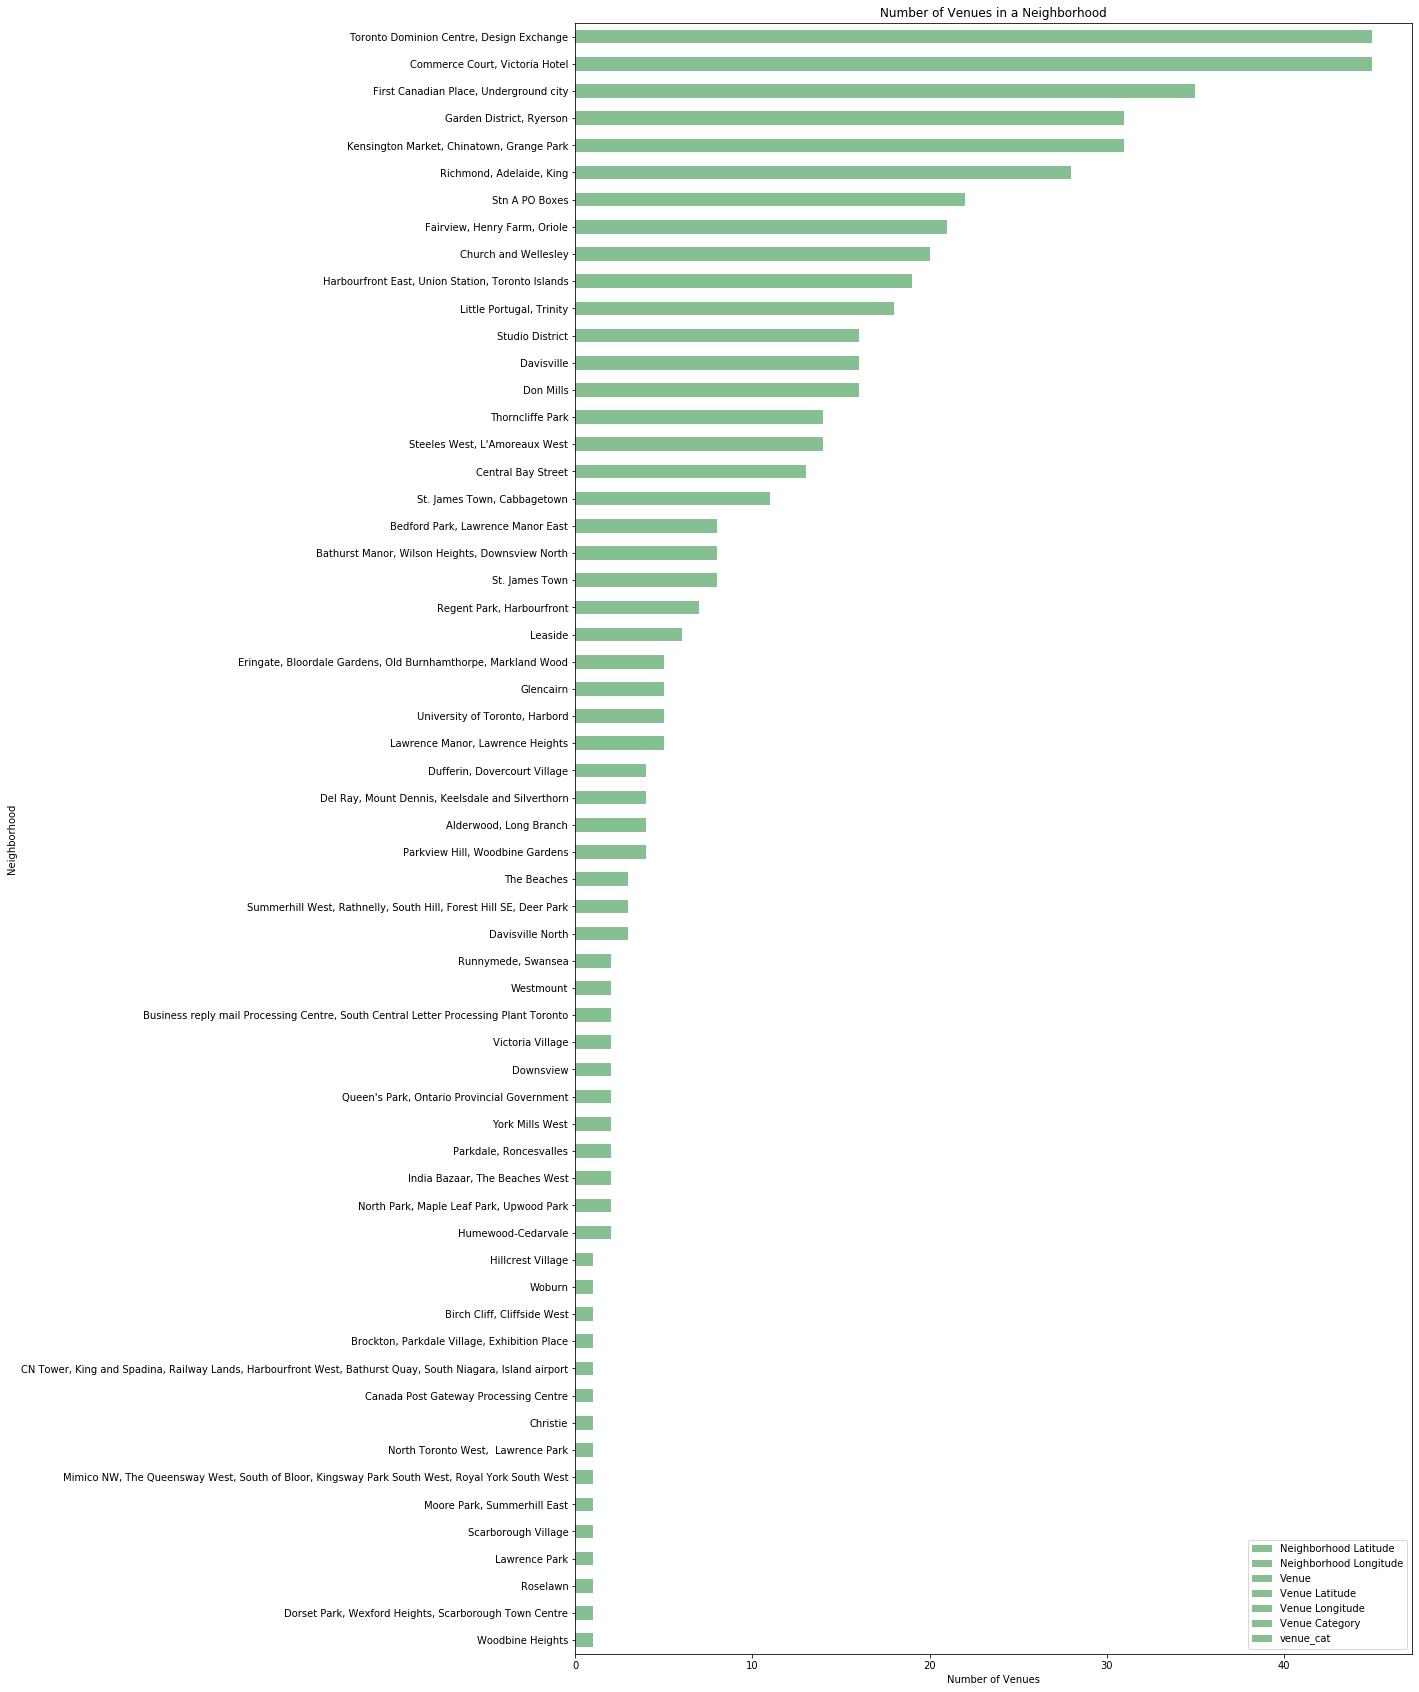

In [257]:
#plot data
fig, ax = plt.subplots(figsize=(15,30))
toronto_venues.groupby('Neighborhood').count().sort_values('Venue Category').plot(kind = 'barh', color='#86bf91',ax=ax)
ax.set_xlabel('Number of Venues')
ax.set_title('Number of Venues in a Neighborhood')

In [258]:
# Count the number of venues within 100 miles of each neighborhood and make a new dataframe
venue_count = toronto_venues.groupby('Neighborhood').count().reset_index()
venue_count.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat
0,"Alderwood, Long Branch",4,4,4,4,4,4,4
1,"Bathurst Manor, Wilson Heights, Downsview North",8,8,8,8,8,8,8
2,"Bedford Park, Lawrence Manor East",8,8,8,8,8,8,8
3,"Birch Cliff, Cliffside West",1,1,1,1,1,1,1
4,"Brockton, Parkdale Village, Exhibition Place",1,1,1,1,1,1,1


In [259]:
# add the latitude and longitude columns to the new data frame.
latitudes = toronto_venues.set_index('Neighborhood').to_dict()['Neighborhood Latitude']
longitudes = toronto_venues.set_index('Neighborhood').to_dict()['Neighborhood Longitude']
venue_count['Latitude'] = venue_count['Neighborhood'].replace(latitudes)
venue_count['Longitude'] = venue_count['Neighborhood'].replace(longitudes)

In [208]:
# Drop the extra columns
cols = [1,2,3,4,5]
venue_count.drop(venue_count.columns[cols],axis=1,inplace=True)
venue_count.head()

,Neighborhood,Venue Category,Latitude,Longitude
0,"Alderwood, Long Branch",4,43.602414,-79.543484
1,"Bathurst Manor, Wilson Heights, Downsview North",8,43.754328,-79.442259
2,"Bedford Park, Lawrence Manor East",8,43.733283,-79.419750
3,"Birch Cliff, Cliffside West",1,43.692657,-79.264848
4,"Brockton, Parkdale Village, Exhibition Place",1,43.636847,-79.428191


In [282]:
venue_count.shape

(60, 10)

#### For each neighborhood find the top 5 venues

In [319]:
grouped  = toronto_venues.groupby(['Neighborhood','Venue Category']).agg({"Venue": "count"})
grouped.head()

Venue
Neighborhood           Venue Category            
Alderwood, Long Branch Accessories Store        0
                       Adult Boutique           0
                       American Restaurant      0
                       Arepa Restaurant         0
                       Art Gallery              0

In [320]:
#group by the first level of the index:
g = grouped['Venue'].groupby(level=0, group_keys=False)

In [322]:
g.sort_values('Venue', ascending=False)

AttributeError: 'SeriesGroupBy' object has no attribute 'sort_values'

In [321]:
#sort ('order') each group and take the first 5 elements:
res = g.apply(lambda x: x.order(ascending=False).head(3))

AttributeError: 'Series' object has no attribute 'order'

#### Number of venues in Neighbhorhoods indicated by bubble size in map

In [212]:
#create map of Toronto and add the venue count for each neighborhood
map_venue = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for cnt, lat, lng, label in zip(venue_count['Venue Category'], venue_count['Latitude'], venue_count['Longitude'], venue_count['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=cnt,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venue)  

map_venue

#### Types of venues?

In [213]:
len(toronto_venues['Venue Category'].unique())

154

In [214]:
toronto_venues.groupby(['Venue Category'])['Neighborhood'].count()

Venue Category
Accessories Store      1
Adult Boutique         1
American Restaurant    2
Arepa Restaurant       1
Art Gallery            4
                      ..
Wine Bar               4
Wine Shop              1
Wings Joint            1
Women's Store          1
Yoga Studio            2
Name: Neighborhood, Length: 154, dtype: int64

### Pre-process the venue data

In [215]:
toronto_venues.dtypes

Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object

#### Encode categorical data

In [216]:
toronto_venues["Venue Category"] = toronto_venues["Venue Category"].astype('category')
toronto_venues.dtypes

Neighborhood                object
Neighborhood Latitude      float64
Neighborhood Longitude     float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category            category
dtype: object

In [217]:
toronto_venues["venue_cat"] = toronto_venues["Venue Category"].cat.codes
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat
0,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection,85
1,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant,61
2,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,9
3,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,33
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa,132


In [218]:
toronto_venues.shape

(534, 8)

In [ ]:
Make a new

### What are the most common venues in each neighborhood?

#### Group the venue data by neighborhoods and get the means

In [235]:
toronto_grouped = toronto_venues.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,venue_cat
0,"Alderwood, Long Branch",43.602414,-79.543484,43.601959,-79.544858,75.500
1,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,43.755009,-79.442045,85.375
2,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,43.733354,-79.419562,79.500
3,"Birch Cliff, Cliffside West",43.692657,-79.264848,43.691666,-79.264532,25.000
4,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,43.638156,-79.427333,114.000


In [236]:
toronto_grouped.shape

(60, 6)

### Use K Mean clutering to identify similar neighborhoods based on venue data

In [245]:
from sklearn.cluster import KMeans 

kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,venue_cat
0,43.602414,-79.543484,43.601959,-79.544858,75.500
1,43.754328,-79.442259,43.755009,-79.442045,85.375
2,43.733283,-79.419750,43.733354,-79.419562,79.500
3,43.692657,-79.264848,43.691666,-79.264532,25.000
4,43.636847,-79.428191,43.638156,-79.427333,114.000


In [246]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_ 

In [247]:
print(labels)

[1 3 3 2 0 2 0 2 1 3 1 1 1 4 3 1 3 3 1 3 1 1 1 1 1 1 3 3 1 2 3 1 1 0 0 2 0
 1 1 0 1 3 1 3 0 1 4 1 1 4 3 0 3 1 4 1 1 3 2 1]


#### Map showing similar neighborhoods with matching colors that were clustered based on availability of different venues

In [255]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_grouped['Neighborhood Latitude'], 
                                  toronto_grouped['Neighborhood Longitude'], 
                                  toronto_grouped['Neighborhood'], 
                                  labels):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters